In [4]:
import numpy as np
import mne
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# def plot_topomap_connectivity_2d(info, con, picks=None, pairs=None, vmin=None, vmax=None, cm=None, 
#                                  show_values=False, show_names=True):
#     """
#     Plots connectivity-like data in 2d
    
#     Drawing every pair of channels will likely make a mess
#     There are two options to avoid it:
#     - provide picks
#     - provide specific pairs of channels to draw
#     """
    
#     # get positions
#     _, pos, _, _, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');
    
# #     if picks is None and pairs is None:
# #         picks = info.ch_names
    
#     ch_names_lower = [ch.lower() for ch in info.ch_names]
#     if picks:
#         picks_lower = [ch.lower() for ch in picks]
#     if pairs:
#         pairs_lower = [tuple(sorted([ch1.lower(), ch2.lower()])) for ch1, ch2 in pairs]
    
#     rows = []
#     for idx1, ch1 in enumerate(ch_names_lower):
#         for idx2, ch2 in enumerate(ch_names_lower):
#             if ch1 >= ch2:
#                 continue
#             if picks and (ch1 not in picks_lower or ch2 not in picks_lower):
#                     continue
#             if pairs and (ch1, ch2) not in pairs_lower:
#                     continue
#             rows.append((
#                 pos[idx1],
#                 pos[idx2],
#                 con[idx1, idx2]
#             ))
    
#     if not len(rows):
#         raise ValueError('No pairs to plot')
    
#     con_to_plot = np.array([row[2] for row in rows])
#     if vmin is None:
#         vmin = np.percentile(con_to_plot, 2)
#     if vmax is None:
#         vmax = np.percentile(con_to_plot, 98)
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
#     if cm is None:
#         cm = sns.diverging_palette(240, 10, as_cmap=True)
    
#     fig, ax = plt.subplots(figsize=[5, 5])
#     mne.viz.utils.plot_sensors(info, show_names=show_names, show=False, axes=ax);
#     for row in rows:
#         rgba_color = cm(norm(row[2]))
#         plt.plot([row[0][0], row[1][0]], [row[0][1], row[1][1]], color=rgba_color)
#         if show_values:
#             plt.text((row[0][0] + row[1][0]) / 2, 
#                      (row[0][1] + row[1][1]) / 2, 
#                      '{:.2f}'.format(row[2]))

In [7]:
# 8 channels from 10-20 montage system.
channels = [
    # frontal
    'Fz',
    # central and temporal
    'C3',
    'Cz',
    'C4',
    # parietal
    'Po7',
    'Pz',
    'Po8',
    # occipital
    'Oz',
]

In [17]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
print(ten_twenty_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


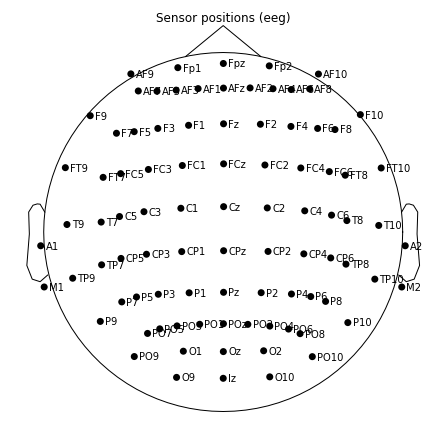

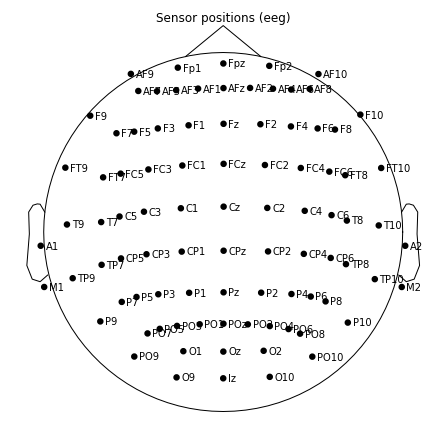

In [23]:
ten_twenty_montage.plot(kind='topomap', show_names=True)

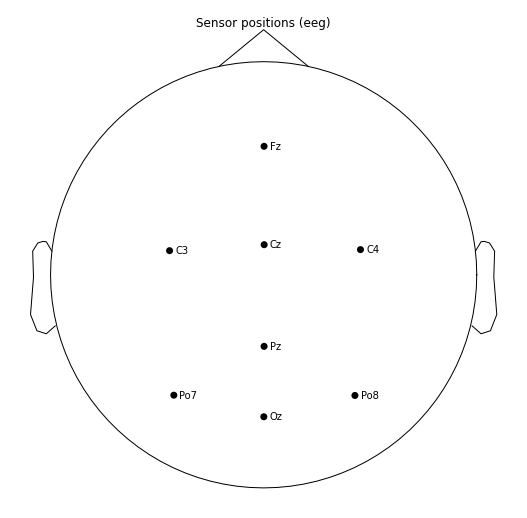

In [28]:
# plot EEG montage

def rename_ch(ch_old):
    if ch_old[-2] == '.':
        return ch_old[:-2]
    else:
        return ch_old[:-1]

sample = mne.io.read_raw_edf('S003R03.edf', verbose=False, preload=True)
sample.rename_channels(rename_ch)
sample = sample.pick_channels(channels)
ch_map = {ch.lower(): ch for ch in sample.ch_names}
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
ten_twenty_montage.ch_names = [ch_map[ch.lower()] if ch.lower() in ch_map else ch 
                               for ch in ten_twenty_montage.ch_names]
sample.set_montage(ten_twenty_montage)

# plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
sample.plot_sensors(show_names=True, axes=ax)
plt.show()

In [47]:
loc_3d = [list(el.values())[0]
          for el in list(ten_twenty_montage.dig)]

loc_3d_dict = {ch_name: loc
               for loc, ch_name in zip(loc_3d, list(ten_twenty_montage.ch_names))}
loc_3d_dict = {ch_name: loc
               for ch_name, loc in loc_3d_dict.items()
               if ch_name in channels}
loc_3d_dict

{'Fz': array([-0.06178852,  0.04604038,  0.01621827]),
 'C3': array([-0.08232689, -0.01517133, -0.04627779]),
 'Cz': array([-0.07694604, -0.01318826,  0.02794898]),
 'C4': array([-0.03465635, -0.00956927,  0.08602457]),
 'Pz': array([-0.06447846, -0.07312232,  0.02720329]),
 'Po7': array([ 0.07002167, -0.07003375, -0.00243451]),
 'Po8': array([ 0.01905208, -0.09756551,  0.04446628]),
 'Oz': array([ 0.05335475, -0.0935707 ,  0.00261662])}

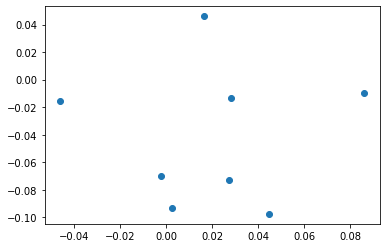

In [53]:
locs = []

for ch_name, loc in loc_3d_dict.items():
    locs.append(loc)

locs = np.stack(locs, axis=0)

plt.scatter(locs[:, 2], locs[:, 1])

In [56]:
montage = mne.channels.make_standard_montage('standard_1020')
n_channels = len(montage.ch_names)
fake_info = mne.create_info(ch_names=montage.ch_names, sfreq=250.,
                            ch_types='eeg')


data = np.random.normal(size=(n_channels, 1)) * 1e-6
fake_evoked = mne.EvokedArray(data, fake_info)
fake_evoked.set_montage(montage)

<Evoked | '' (average, N=1), [0, 0] sec, 94 ch, ~252 kB>

In [73]:
ch_mod = [ch if ch in fake_evoked.ch_names else ch.upper()
          for ch in channels]
ch_idx = [fake_evoked.ch_names.index(ch) for ch in ch_mod]
pos = np.stack([fake_evoked.info['chs'][idx]['loc'][:3] for idx in ch_idx])

In [74]:
pos

array([[ 2.67659515e-04,  8.32601351e-02,  1.03769886e-01],
       [-6.26671352e-02,  1.60590166e-02,  1.06780419e-01],
       [ 3.51595666e-04,  2.10002776e-02,  1.40918291e-01],
       [ 6.43072058e-02,  1.67191290e-02,  1.06016367e-01],
       [-5.25614000e-02, -7.04584885e-02,  5.41083430e-02],
       [ 2.90848487e-04, -4.90318933e-02,  1.29235864e-01],
       [ 5.33562321e-02, -7.05417197e-02,  5.40828144e-02],
       [ 1.03510873e-04, -8.61955604e-02,  6.67089245e-02]])

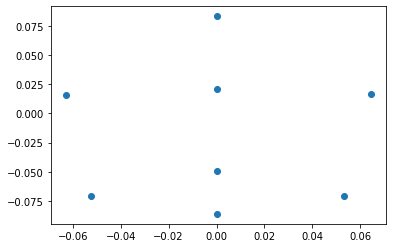

In [76]:
plt.scatter(pos[:, 0], pos[:, 1])

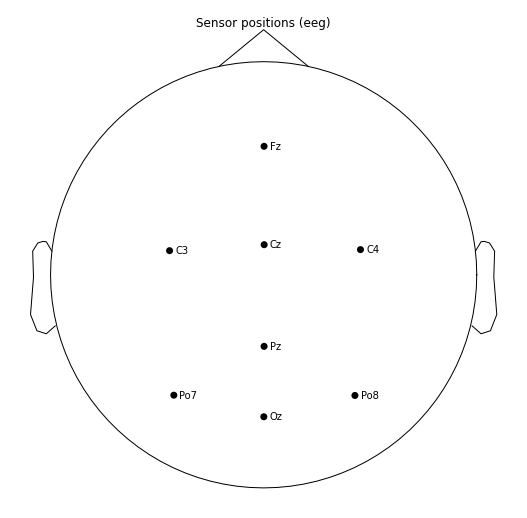

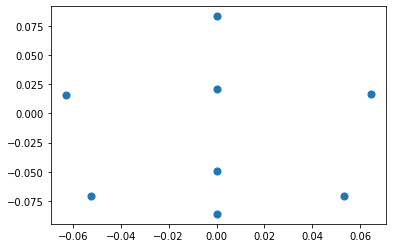

In [82]:
def rename_ch(ch_old):
    if ch_old[-2] == '.':
        return ch_old[:-2]
    else:
        return ch_old[:-1]

sample = mne.io.read_raw_edf('S003R03.edf', verbose=False, preload=True)
sample.rename_channels(rename_ch)
sample = sample.pick_channels(channels)
ch_map = {ch.lower(): ch for ch in sample.ch_names}
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
ten_twenty_montage.ch_names = [ch_map[ch.lower()] if ch.lower() in ch_map else ch 
                               for ch in ten_twenty_montage.ch_names]
sample.set_montage(ten_twenty_montage)

# plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
sample.plot_sensors(show_names=True, axes=ax)

plt.scatter(pos[:, 0], pos[:, 1], s=50)

plt.show() 